# How goes the marketing?

Now we are analysts in the analytical department at Yandex.Afisha. Our task is to help optimize marketing expenses. We  have server logs with data on Yandex.Afisha visits from June 2017 through May 2018, dump file with all orders for the period and marketing expenses statistics.
 
 ## Purposes of the analysis
 
Purposes of the analysis are to find out how people use the product, when they start to buy, how much money each customer brings to the company, when they pay off. 

## Initialization

In [1]:
# Loading all the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from functools import reduce
from dateutil.relativedelta import relativedelta
import datetime
from datetime import timedelta

## Load data

In [2]:
# Load the data files
try:
    visits = pd.read_csv('/datasets/visits_log_us.csv')
except FileNotFoundError:
    visits = pd.read_csv('E:\\Израиль\\Practicum\\Project 7\\visits_log_us.csv')
try:
    orders = pd.read_csv('/datasets/orders_log_us.csv')
except FileNotFoundError:
    orders = pd.read_csv('E:\\Израиль\\Practicum\\Project 7\\orders_log_us.csv')
try:
    costs = pd.read_csv('/datasets/costs_us.csv')
except FileNotFoundError:
    costs = pd.read_csv('E:\\Израиль\\Practicum\\Project 7\\costs_us.csv')

### Explore initial data

The `visits` table contains the following columns:
- `Uid` - user's unique identifier
- `Device` -  user's device
- `Start Ts` - session start date and time
- `End Ts` - session end date and time
- `Source Id` - identifier of the ad source the user came from

The `orders` table contains the following columns:
- `Uid` - unique identifier of the user making an order
- `Buy Ts` - order date and time
- `Revenue` - Yandex.Afisha's revenue from the order

The `costs` table contains the following columns:
- `source_id`   ad source identifier
- `dt` - date
- `costs` - expenses on this ad source on this day

In [3]:
# printing the general/summary information about visits table
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [4]:
# print a sample of data from visits table
visits.head(10)

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451
7,touch,2017-11-05 15:15:00,3,2017-11-05 15:14:00,11423865690854540312
8,desktop,2017-07-19 10:44:00,3,2017-07-19 10:41:00,2987360259350925644
9,desktop,2017-11-08 13:43:00,5,2017-11-08 13:42:00,1289240080042562063


In [5]:
# print a sample of data from visits table
visits.tail(10)

,Device,End Ts,Source Id,Start Ts,Uid
359390,desktop,2017-12-11 17:54:19,1,2017-12-11 17:54:00,18268369011883553090
359391,touch,2017-08-30 11:53:19,2,2017-08-30 11:53:00,18304232853749481866
359392,desktop,2017-12-30 21:49:19,4,2017-12-30 21:49:00,18311497973035795342
359393,desktop,2017-06-08 07:49:19,4,2017-06-08 07:49:00,18325675073358289850
359394,touch,2017-11-06 08:00:19,4,2017-11-06 08:00:00,18332905065174083046
359395,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539
359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586
359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485
359399,touch,2017-09-10 13:13:19,2,2017-09-10 13:13:00,18396128934054549559


In [6]:
# print a sample of data from visits table
visits.sample(10)

,Device,End Ts,Source Id,Start Ts,Uid
344891,desktop,2017-10-30 10:08:00,3,2017-10-30 10:08:00,2110801324690163805
350844,touch,2018-01-01 20:53:00,3,2018-01-01 20:34:00,5418045948263486572
15751,touch,2017-12-23 19:24:00,1,2017-12-23 19:24:00,2953194607929178298
236212,touch,2017-10-24 00:56:00,5,2017-10-24 00:48:00,10897603657086166048
295113,desktop,2018-01-19 22:45:00,3,2018-01-19 22:28:00,9541766324445570478
291703,touch,2018-03-16 15:30:00,4,2018-03-16 15:24:00,3466253583941683528
240248,desktop,2017-12-15 09:57:00,4,2017-12-15 09:53:00,1486982370811751998
284967,desktop,2017-12-11 21:04:00,4,2017-12-11 21:00:00,3404353374529095838
98456,desktop,2017-06-01 11:19:00,3,2017-06-01 10:43:00,11062788618907079633
287709,desktop,2018-01-17 02:29:00,5,2018-01-17 02:23:00,9635783068588436459


In [7]:
# printing the general/summary information about orders table
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [8]:
# print a sample of data from orders table
orders.head(10)

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450
5,2017-06-01 08:43:00,0.18,10402394430196413321
6,2017-06-01 08:54:00,1.83,12464626743129688638
7,2017-06-01 09:22:00,1.22,3644482766749211722
8,2017-06-01 09:22:00,3.30,17542070709969841479
9,2017-06-01 09:23:00,0.37,1074355127080856382


In [9]:
# print a sample of data from orders table
orders.tail(10)

,Buy Ts,Revenue,Uid
50405,2018-05-31 23:36:00,0.61,1551265230644458155
50406,2018-05-31 23:40:00,1.16,13121453305610619664
50407,2018-05-31 23:40:00,2.26,15576344609395725707
50408,2018-05-31 23:42:00,0.92,15854392578508828030
50409,2018-05-31 23:43:00,3.67,1805512004303848280
50410,2018-05-31 23:50:00,4.64,12296626599487328624
50411,2018-05-31 23:50:00,5.80,11369640365507475976
50412,2018-05-31 23:54:00,0.30,1786462140797698849
50413,2018-05-31 23:56:00,3.67,3993697860786194247
50414,2018-06-01 00:02:00,3.42,83872787173869366


In [10]:
# print a sample of data from orders table
orders.sample(10)

,Buy Ts,Revenue,Uid
29526,2018-01-15 19:44:00,2.44,18184156529151112188
19006,2017-11-23 18:42:00,9.17,8632810496880662367
45276,2018-04-24 09:34:00,3.50,2569181675832811876
9342,2017-09-27 16:51:00,0.78,17161698392905129055
43385,2018-04-07 14:05:00,17.11,14691451025075033977
39817,2018-03-14 15:18:00,3.67,14566420758479651768
9914,2017-10-01 01:21:00,1.10,1490141628090474038
32072,2018-01-31 15:46:00,2.87,1046453112605608848
28404,2018-01-07 12:30:00,1.53,11243738865346640247
4061,2017-07-20 18:24:00,4.89,15366196411785357542


In [11]:
# printing the general/summary information about costs table
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [12]:
# print a sample of data from costs table
costs.head(10)

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
5,1,2017-06-06,40.39
6,1,2017-06-07,40.59
7,1,2017-06-08,56.63
8,1,2017-06-09,40.16
9,1,2017-06-10,43.24


In [13]:
# print a sample of data from costs table
costs.tail(10)

,source_id,dt,costs
2532,10,2018-05-22,21.70
2533,10,2018-05-23,7.42
2534,10,2018-05-24,10.79
2535,10,2018-05-25,22.21
2536,10,2018-05-26,7.89
2537,10,2018-05-27,9.92
2538,10,2018-05-28,21.26
2539,10,2018-05-29,11.32
2540,10,2018-05-30,33.15
2541,10,2018-05-31,17.60


In [14]:
# print a sample of data from costs table
costs.sample(10)

,source_id,dt,costs
2013,9,2017-12-15,24.44
1478,5,2017-06-27,80.62
770,3,2017-07-15,306.19
18,1,2017-06-19,25.08
2129,9,2018-04-12,11.86
795,3,2017-08-09,146.72
952,3,2018-01-13,340.15
2391,10,2017-12-30,10.32
615,2,2018-02-08,133.54
301,1,2018-03-29,40.00


Generally speaking, our data looks good. There are no missing values we just need to do the following: <br> In `visits` table we will change column names to lowercase with the use of underscore between the words, after that we will change type of `device` column to category type, and also `start_ts` and `end_ts` to datetime type in order to work with the dates properly. <br> In `orders` table we will also change column names to lowercase with the use of underscore between the words and after that we will change type of the `buy_ts` column to datetime type. <br> In `costs` table we just need to change the type of `dt` column to datetime type.<br> We have noticed that dates in our data files are in the pandas format, we do not need to set the format for to_datetime method when changing the types of the columns

# Preprocessing. Column names and types of the columns

In [15]:
#Data preprocessing with visits table

#Changing column names
visits.columns = ['device', 'end_ts', 'source_id', 'start_ts', 'uid']

#Changing the type of `device` column
visits['device'] = visits['device'].astype('category')

#Changing the type of `start_ts` and `end_ts` columns
visits['start_ts'] = pd.to_datetime(visits['start_ts'])
visits['end_ts'] = pd.to_datetime(visits['end_ts'])

#Checking the types of the columns
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   device     359400 non-null  category      
 1   end_ts     359400 non-null  datetime64[ns]
 2   source_id  359400 non-null  int64         
 3   start_ts   359400 non-null  datetime64[ns]
 4   uid        359400 non-null  uint64        
dtypes: category(1), datetime64[ns](2), int64(1), uint64(1)
memory usage: 11.3 MB


In [16]:
#Short look on `visits` table after changes
visits.head(10)

,device,end_ts,source_id,start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451
7,touch,2017-11-05 15:15:00,3,2017-11-05 15:14:00,11423865690854540312
8,desktop,2017-07-19 10:44:00,3,2017-07-19 10:41:00,2987360259350925644
9,desktop,2017-11-08 13:43:00,5,2017-11-08 13:42:00,1289240080042562063


Our visits table now looks fine. Correct types and names of the columns. Let's do what we planned with orders and costs tables.

In [17]:
#Data preprocessing with orders table

#Changing column names
orders.columns = ['buy_ts', 'revenue', 'uid']

#Changing the type of `buy_ts` columns
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])

#Checking the types of the columns
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   buy_ts   50415 non-null  datetime64[ns]
 1   revenue  50415 non-null  float64       
 2   uid      50415 non-null  uint64        
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


In [18]:
#Short look on `orders` table after changes
orders.head(10)

,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450
5,2017-06-01 08:43:00,0.18,10402394430196413321
6,2017-06-01 08:54:00,1.83,12464626743129688638
7,2017-06-01 09:22:00,1.22,3644482766749211722
8,2017-06-01 09:22:00,3.30,17542070709969841479
9,2017-06-01 09:23:00,0.37,1074355127080856382


In [19]:
#Data preprocessing with costs table

#Changing the type of `dt` column
costs['dt'] = pd.to_datetime(costs['dt'])

#Checking the types of the columns
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source_id  2542 non-null   int64         
 1   dt         2542 non-null   datetime64[ns]
 2   costs      2542 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


In [20]:
#Short look on `costs` table after changes
costs.head(10)

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
5,1,2017-06-06,40.39
6,1,2017-06-07,40.59
7,1,2017-06-08,56.63
8,1,2017-06-09,40.16
9,1,2017-06-10,43.24


That's it for the preprocessing stage of the project. Now we have correct types of the data and we can start our analysis. We will make reports and calculate metrics for product,  sales,  and marketing part of our task.

# Reports and metrics

## Product reports and metrics
In order to make conclusions, how users use the product we need to answer several questions. 
1. How many people use it every day, week, and month?
2. How many sessions are there per day for every user?
3. What is the length of each session?
4. What's the user retention rate?

### Daily, weekly and monthly users, session length
Let's start with the first questions. In our `visits` table we have direct information about the date and time of each session. So let's make new columns `sess_year`, `sess_month`, `sess_week`, `sess_date`. We can extract this info from the `start_ts` column. We need to get values of these columns as dates as our analysis period is from the middle of 2017 to the middle of 2018 year.

In [21]:
#Creating year column in visits table
visits['sess_year'] = visits.start_ts.dt.isocalendar().year

#Creating `sess_month` column in visits table
visits['sess_month'] = (visits.start_ts - pd.to_timedelta(
    visits.start_ts.dt.day, unit='d') + timedelta(days=1)).dt.date

#Creating `sess_week` column in visits table
visits['sess_week'] = (visits.start_ts - pd.to_timedelta(
    visits.start_ts.dt.dayofweek, unit='d')).dt.date

#Creating `sess_date` column in visits table
visits['sess_date'] = visits.start_ts.dt.date

#Checking that it works
visits.head(5)

,device,end_ts,source_id,start_ts,uid,sess_year,sess_month,sess_week,sess_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,2017-12-01,2017-12-18,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2018-02-01,2018-02-19,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,2017-07-01,2017-06-26,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,2018-05-01,2018-05-14,2018-05-20
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,2017-12-01,2017-12-25,2017-12-27


Lets find dau, wau and mau metrics: the average number of user that use the product every day, week, month. In order to calculate that metrics we will use groupby method with the nunique function that will calculate the number of unique users.

In [22]:
#Calculating dau
dau_total = visits.groupby('sess_date').agg({'uid':'nunique'}).mean()

#Calculating wau
wau_total = visits.groupby('sess_week').agg({'uid':'nunique'}).mean()

#Calculating mau
mau_total = visits.groupby('sess_month').agg({'uid':'nunique'}).mean()

#Calculating sticky factors
sf_w = dau_total / wau_total
sf_m = dau_total / mau_total
#Printing the results
print('Average number of daily users:', int(dau_total))
print('Average number of weekly users:',int(wau_total), 'sticky factor:', round(float(sf_w),2))
print('Average number of monthly users:',int(mau_total), 'sticky factor:', round(float(sf_m),2))

Average number of daily users: 907
Average number of weekly users: 5716 sticky factor: 0.16
Average number of monthly users: 23228 sticky factor: 0.04


We see that in average there are 907 users who use the product every day. Also only 16% of the users who have used the product at least once a week, continue to do it every day,  and only 4% of the users who have used the product at least once a month, continue to use it every day. In addition we see that about 25% of users who have used the service once a month us it weekly. 
Not so many users like to use the product regularly, may be we need to find the way how to involve more people to our product.<br>
Let' look how dau,  wau and mau change in time. We will plot line graph and mark the mean value to see the dynamic of daily, weekly and monthly users

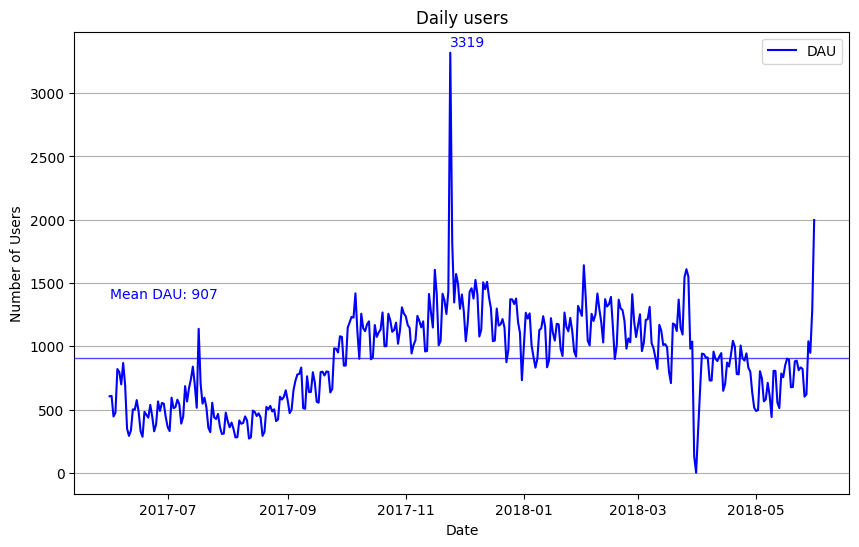

In [23]:

#Calculating dau, wau and mau
dau = visits.groupby('sess_date').agg({'uid':'nunique'}).reset_index()
wau = visits.groupby('sess_week').agg({'uid':'nunique'}).reset_index()
mau = visits.groupby('sess_month').agg({'uid':'nunique'}).reset_index()

#Plotting line graphs for daily users
fig, ax = plt.subplots(figsize = (10,6))
ax.grid(axis ='y')
ax.plot(dau['sess_date'], dau['uid'], label = 'DAU', color = 'blue')

#Adding h-line with mean dau 
plt.axhline(y=int(dau_total), linewidth=1, color = 'blue', alpha = 0.7)
ax.text(dau['sess_date'].iloc[0], dau_total+500, f"Mean DAU: {int(dau_total)}", color='blue', va='center')

#Adding additional info
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Number of Users')
ax.set_title('Daily users')

#Adding info about the maximum values for dau
dau_max = dau['uid'].max()
max_date = dau[dau['uid']==dau_max]['sess_date'].iloc[0]
ax.annotate(int(dau_max), xy=(max_date, dau_max), xytext=(max_date, dau_max+50), color = 'blue')
plt.show()

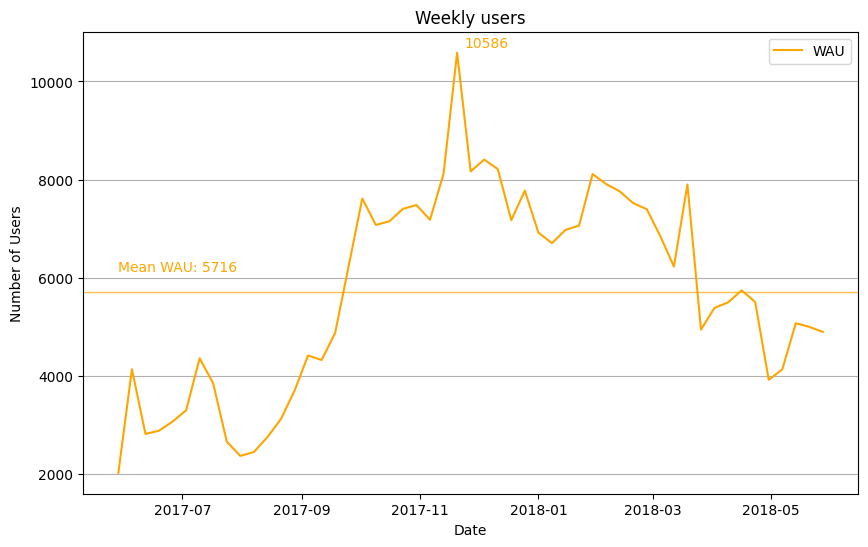

In [24]:
#Plotting line graphs for weekly users
fig, ax = plt.subplots(figsize = (10,6))
ax.grid(axis ='y')
ax.plot(wau['sess_week'], wau['uid'], label = 'WAU', color = 'orange')

#Adding h-line with mean wau 
plt.axhline(y=int(wau_total), linewidth=1, color = 'orange', alpha = 0.7)
ax.text(wau['sess_week'].iloc[0], wau_total+500, f"Mean WAU: {int(wau_total)}", color='orange', va='center')

#Adding additional info
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Number of Users')
ax.set_title('Weekly users')


#Adding info about the maximum values for dau and wau
wau_max = wau['uid'].max()
ax.annotate(int(wau_max), xy=(max_date, wau_max), xytext=(max_date, wau_max+100), color = 'orange')
plt.show()

We see that our DAU is more or less stable, There is small increase in the January 2018. There is sudden peak in one day the dau is 3319, but it was only one day, after that dau returned to its original value.<br>
In  the same time we see that wau changes in time significantly. We have increas from 2000 users in August 2017 to 7800 users in October 2017. And we have this level stable till April 2018, after that date dau began to decrease. That means that our sticky factor is falling down. In average it is 16% but  for the period form October 2017 till April 2018 it is about 12%. So, less users used the product on the daily basis. For wau we have obviously the same peak of 10586 users. May be there was very popular event at that date and many users decided to book it. 

Let's look at MAU and compare it with WAU 

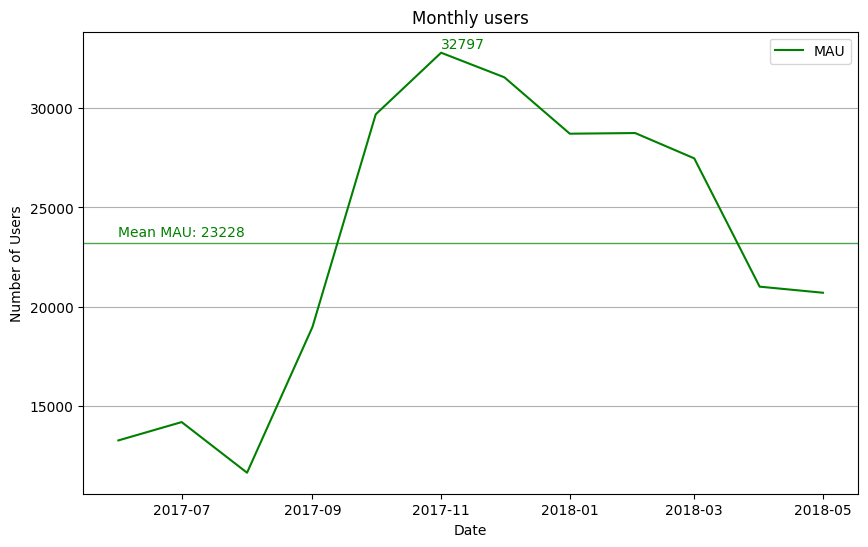

In [25]:
#Plotting line graphs for monthly users
fig, ax = plt.subplots(figsize = (10,6))
ax.grid(axis ='y')
ax.plot(mau['sess_month'], mau['uid'], label = 'MAU', color = 'green')

#Adding h-line with mean mau 
plt.axhline(y=int(mau_total), linewidth=1, color = 'green', alpha = 0.7)
ax.text(mau['sess_month'].iloc[0], mau_total+500, f"Mean MAU: {int(mau_total)}", color='green', va='center')

#Adding additional info
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Number of Users')
ax.set_title('Monthly users')

#Adding info about the maximum values for dau and wau
mau_max = mau['uid'].max()
max_date = mau[mau['uid']==mau_max]['sess_month'].iloc[0]
ax.annotate(int(mau_max), xy=(max_date, mau_max), xytext=(max_date, mau_max+200), color = 'green')
plt.show()

We have the same dynamic and correlation between WAU and MAU from August till October 2017 MAU increases much more than WAU, so we see that in that period users used the product much less regularly.  May be not so many events in the end of the Summer everyone is on vacation.  

Now, let's find number of sessions per each user. We can count the sessions and then we can divide number of sessions to the number of users.

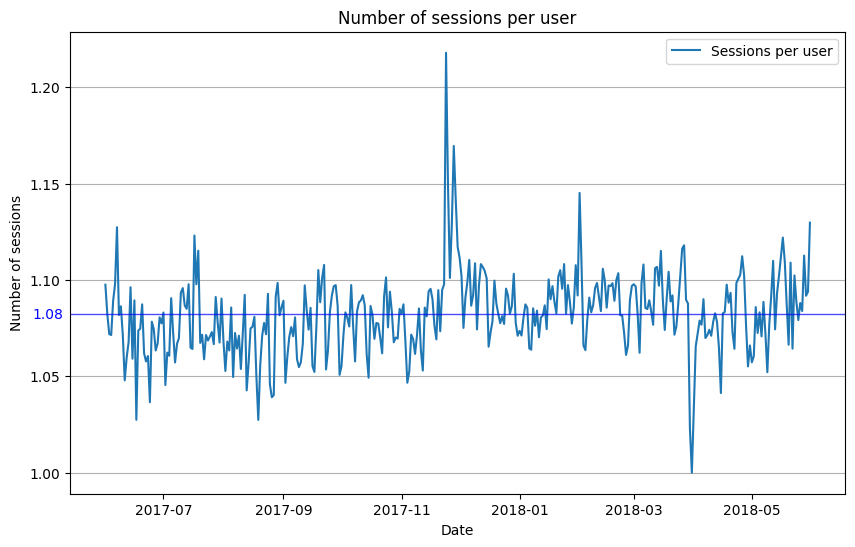

In [26]:
#Creating the session table
sessions = visits.groupby('sess_date').agg({'uid':['count', 'nunique']})

#Renaiming the columns
sessions.columns = ['n_sess', 'n_user']
sessions['sess_per_user'] = sessions.n_sess / sessions.n_user

#Plotting line graph to see the dynamic of session per user
fig, ax = plt.subplots(figsize = (10,6))
ax.grid(axis ='y')
ax.plot(sessions.index, sessions['sess_per_user'], label = 'Sessions per user')

#Adding h-line with mean number of session per user
plt.axhline(y=sessions['sess_per_user'].mean(), linewidth=1, color = 'blue', alpha = 0.7)
mean_sess_per_user = sessions['sess_per_user'].mean()
ax.annotate(f"{mean_sess_per_user:.2f}", 
             xy=(sessions.index[0], mean_sess_per_user), xytext=(-30, 5), 
             textcoords="offset points", ha="right", va="top", color='blue', fontsize=10)


#Adding additional info
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Number of sessions')
ax.set_title('Number of sessions per user')
plt.show()


We see that users open the product just once a day. Number of session is stable throughout all the period of the analysis. We see one high peak where there is 1.23 sessions per user and one low peak where there is 1 session per user. Anyway there is no need for users to book anything more than once a day. <br> Let's plot sessions per user and DAU in one graph to see this more clearly

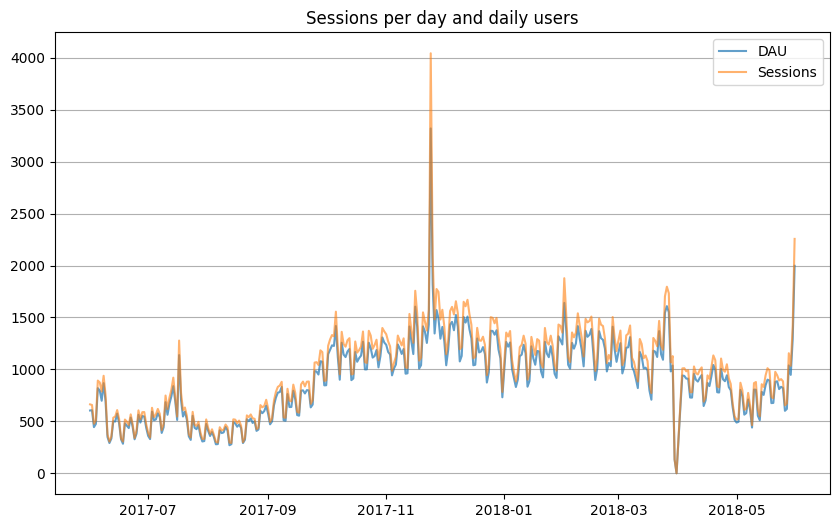

In [27]:
#Plotting line graphs for daily and weekly users
fig, ax = plt.subplots(figsize = (10,6))
ax.grid(axis ='y')
ax.plot(dau['sess_date'], dau['uid'], label = 'DAU', alpha = 0.7)
ax.plot(sessions.index, sessions['n_sess'], label = 'Sessions', alpha = 0.6)
#Adding additional info
ax.legend()
plt.title('Sessions per day and daily users')
plt.show()

We can see here that number of daily users is almost the same as number of daily sessions. So our conclusions that users have just 1 session per day are correct <br>
Let's find the average length of the session. As we have start and end times for each session we can calculate the difference in seconds and then we will plot the histogram to see the distribution and calculate the appropriate average number. We will filter zero sessions as well, we do not want to consider them as usage of the product. 

count    323606.000000
mean        714.684623
std        1047.052806
min          19.000000
25%         120.000000
50%         360.000000
75%         900.000000
max       84480.000000
Name: sess_length, dtype: float64

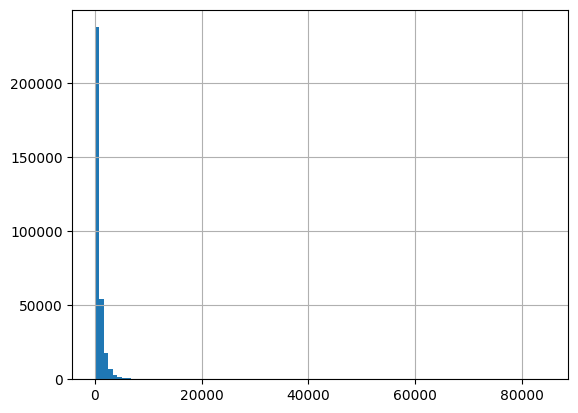

In [28]:
#Calculating the length of the session in seconds
visits['sess_length'] = (visits.end_ts - visits.start_ts).dt.seconds

#Plotting the histogram
visits[visits['sess_length'] >0]['sess_length'].hist(bins = 100)
                          
visits[visits['sess_length'] >0]['sess_length'].describe()

Our distribution is far from the standard, mean and median are not very informative. It is better to use mode to evaluate the most often length of the session as ASL.

In [29]:
#Calculating ASL
asl = visits['sess_length'].mode()

#Printing the result
print('The average  daily session length per user (ASL) is:', int(asl), 'seconds')

The average  daily session length per user (ASL) is: 60 seconds


So most often users spend just 1 minute using the product, but the half of the total number of users spend more than 6 minutes during the one session. Anyway it is not a big time.

Now we need to calculate the users retention rate. In order to do this we will make a cohort analysis. We will divide all users to the cohorts depending on time of their first sessions. We saw that there is data for a year, so we will choose monthly cohorts for our analysis. And we will see how many users from a cohort have remained active compared to their initial number. 
### Cohort analysis
We need to find first date when the user started to use our product, then we calculate first activity month, after that we can calculate retention rate and find the most successful cohort. We just need visits table for that analysis. 

In [30]:
#Finding first activity date for each user
first_activity_date = visits.groupby('uid')['sess_date'].min()
#Renaming the column
first_activity_date.name = 'first_activity_date'
#Adding the `first_activity_date` column to visits table
visits = visits.join(first_activity_date, on = 'uid')

#Checking what was done
visits.sample(5)

,device,end_ts,source_id,start_ts,uid,sess_year,sess_month,sess_week,sess_date,sess_length,first_activity_date
262671,touch,2017-09-27 11:05:00,4,2017-09-27 10:55:00,14601848399293749297,2017,2017-09-01,2017-09-25,2017-09-27,600,2017-09-27
11815,desktop,2018-02-04 20:21:00,4,2018-02-04 20:02:00,10585964217413577610,2018,2018-02-01,2018-01-29,2018-02-04,1140,2018-02-04
312087,desktop,2018-01-02 14:25:00,3,2018-01-02 14:06:00,7908781242142439259,2018,2018-01-01,2018-01-01,2018-01-02,1140,2018-01-02
151553,touch,2018-05-04 21:32:00,2,2018-05-04 21:18:00,1408968102774146156,2018,2018-05-01,2018-04-30,2018-05-04,840,2018-04-25
30871,touch,2017-06-09 15:30:00,5,2017-06-09 15:06:00,2926309585499616959,2017,2017-06-01,2017-06-05,2017-06-09,1440,2017-06-09


Everything is good. Now we need to find the first date of the month to perform our cohorts. We can subtract number of days of the month from the date to get the first date of the specific month for each date.

In [31]:
#Setting the correct type of `first_activity_date` column
visits['first_activity_date'] = pd.to_datetime(visits['first_activity_date'])

#Adding `first_activity_month` column
visits['first_activity_month'] = (visits.first_activity_date - pd.to_timedelta(
    visits.first_activity_date.dt.day, unit='d') + timedelta(days=1)).dt.date

#Checking the result
visits.sample(5)

,device,end_ts,source_id,start_ts,uid,sess_year,sess_month,sess_week,sess_date,sess_length,first_activity_date,first_activity_month
109103,desktop,2018-03-25 12:44:00,3,2018-03-25 12:40:00,304062806664131059,2018,2018-03-01,2018-03-19,2018-03-25,240,2018-03-25,2018-03-01
40110,desktop,2017-06-07 11:52:00,4,2017-06-07 11:43:00,11293862434495144767,2017,2017-06-01,2017-06-05,2017-06-07,540,2017-06-07,2017-06-01
139288,desktop,2017-06-16 18:11:00,3,2017-06-16 18:10:00,8808477015725594142,2017,2017-06-01,2017-06-12,2017-06-16,60,2017-06-16,2017-06-01
243074,touch,2017-11-29 22:46:00,4,2017-11-29 22:37:00,903888275735815131,2017,2017-11-01,2017-11-27,2017-11-29,540,2017-11-29,2017-11-01
112133,desktop,2017-07-04 21:46:00,3,2017-07-04 21:34:00,12928559909632549437,2017,2017-07-01,2017-07-03,2017-07-04,720,2017-07-04,2017-07-01


Let' do the same thing and add `activity_week` from the `sess_date` column

In [32]:
#Setting the correct type of `sess_date` column
visits['sess_date'] = pd.to_datetime(visits['sess_date'])

#Adding `activity_month` column
visits['activity_month'] = (visits.sess_date - pd.to_timedelta(
    visits.sess_date.dt.day, unit='d') + timedelta(days=1)).dt.date

#Checking the result
visits.sample(5)

,device,end_ts,source_id,start_ts,uid,sess_year,sess_month,sess_week,sess_date,sess_length,first_activity_date,first_activity_month,activity_month
243213,touch,2018-05-30 17:58:00,1,2018-05-30 17:45:00,12904778656959662589,2018,2018-05-01,2018-05-28,2018-05-30,780,2018-05-30,2018-05-01,2018-05-01
54658,desktop,2018-03-13 11:38:00,3,2018-03-13 11:37:00,7197583939945719301,2018,2018-03-01,2018-03-12,2018-03-13,60,2017-07-10,2017-07-01,2018-03-01
319711,touch,2017-10-27 14:10:00,1,2017-10-27 13:43:00,17443502376058293769,2017,2017-10-01,2017-10-23,2017-10-27,1620,2017-10-27,2017-10-01,2017-10-01
358141,desktop,2017-08-17 01:24:00,3,2017-08-17 01:24:00,10475520819914726833,2017,2017-08-01,2017-08-14,2017-08-17,0,2017-08-17,2017-08-01,2017-08-01
80555,desktop,2017-10-06 12:14:00,3,2017-10-06 12:10:00,2576300499481050128,2017,2017-10-01,2017-10-02,2017-10-06,240,2017-10-06,2017-10-01,2017-10-01


Now we can calculate user lifetime within the cohort for each row of the visits table. We will divide the  difference between `activity_month` and `first_activity_month` to the constant value np.timedelta64(1,'M') and we will get the number of active months. Then we will make this value as integer to get the correct result

In [33]:
#Calculating cohort lifetime
visits['cohort_lifetime'] = ((
    visits['activity_month'] - visits['first_activity_month']) / np.timedelta64(1,'M')).round().astype(int)

#Checking the result
visits.sample(5)

,device,end_ts,source_id,start_ts,uid,sess_year,sess_month,sess_week,sess_date,sess_length,first_activity_date,first_activity_month,activity_month,cohort_lifetime
61147,desktop,2018-03-05 11:59:00,3,2018-03-05 11:21:00,14942259893916638337,2018,2018-03-01,2018-03-05,2018-03-05,2280,2018-03-05,2018-03-01,2018-03-01,0
46011,desktop,2018-01-13 21:27:00,3,2018-01-13 21:25:00,6232718672745241852,2018,2018-01-01,2018-01-08,2018-01-13,120,2018-01-13,2018-01-01,2018-01-01,0
320928,touch,2017-11-26 17:52:00,3,2017-11-26 17:49:00,7794133586070248038,2017,2017-11-01,2017-11-20,2017-11-26,180,2017-11-21,2017-11-01,2017-11-01,0
125154,desktop,2018-01-14 22:08:00,3,2018-01-14 22:08:00,16462846768450770832,2018,2018-01-01,2018-01-08,2018-01-14,0,2017-08-13,2017-08-01,2018-01-01,5
163084,desktop,2017-12-12 14:53:00,3,2017-12-12 14:52:00,6591676072079668906,2017,2017-12-01,2017-12-11,2017-12-12,60,2017-12-12,2017-12-01,2017-12-01,0


Now we have all necessary information to calculate the retention rate. We can group the visits table with first activity month and cohort lifetime and calculate the number of unique users in each lifetime week for each cohort. Then we can divide the number of users in each lifetime month to the number of users in first activity month and we will get the retention rate.

In [34]:
#Creating cohort table
cohorts = visits.groupby(['first_activity_month', 'cohort_lifetime']).agg({'uid':'nunique'}).reset_index()

#Calculating the initial number of users for each cohort
init_uid_count = cohorts[cohorts['cohort_lifetime']==0][['first_activity_month', 'uid']]
#Renaming the column for initial number of cohort users
init_uid_count=init_uid_count.rename(columns={'uid':'cohort_count'})

#Adding the column `cohort_count` to cohorts table
cohorts = cohorts.merge(init_uid_count, on='first_activity_month')

#Checking the result
cohorts.sample(10)


,first_activity_month,cohort_lifetime,uid,cohort_count
51,2017-11-01,1,2133,27248
73,2018-03-01,1,861,20589
46,2017-10-01,4,890,25977
60,2017-12-01,3,786,25268
21,2017-07-01,9,376,13140
65,2018-01-01,2,890,22624
34,2017-09-01,1,1428,16704
68,2018-02-01,0,22197,22197
49,2017-10-01,7,529,25977
75,2018-04-01,0,15709,15709


Now we are ready to calculate the retention rate. We just need to divide `uid` column to `cohort_count`. End then we will make pivot table and plot  the heat map to visualize the picture

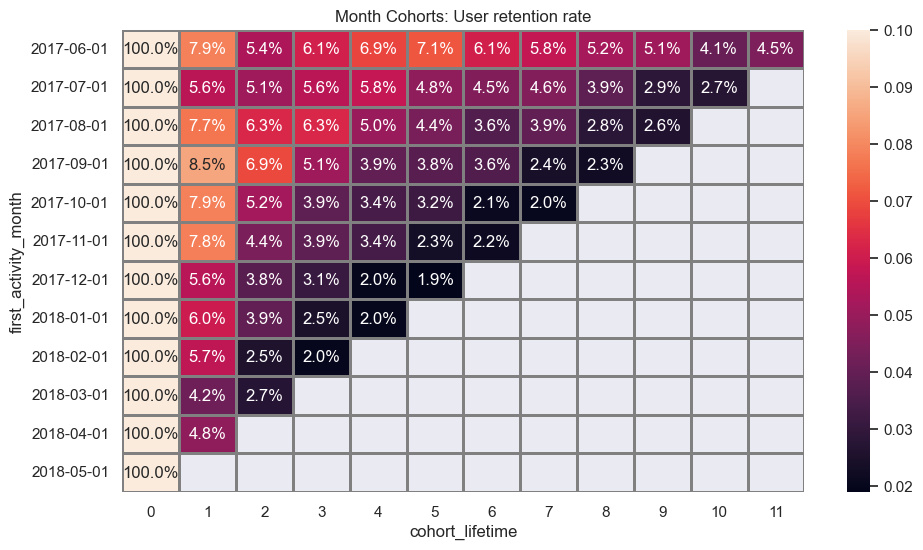

In [35]:
#Calculating Retention rate column
cohorts['retention'] = cohorts.uid / cohorts.cohort_count

#Creating Pivot to get retention picture
retention = cohorts.pivot_table(
    index='first_activity_month', columns='cohort_lifetime', values = 'retention', aggfunc='sum')

# plotting the heatmap of the retention
sns.set(style='dark')
plt.figure(figsize=(11,6))
sns.heatmap(retention, annot=True, fmt='.1%', linewidths=1, vmax=0.1, linecolor='gray')
plt.title('Month Cohorts: User retention rate')
plt.show()

Our retention rate is not big, less then 10% of users continue using the product after the first month when they began to use it. The most successful cohort is the first one (June Cohort). They have 7.9% of users who continue to use the service in the next month after the first usage and the have this retention rate for the next 6 months. Then after 6 months retention rate begin to drop to 4.5% in May 2018. The September Cohort gas the highest  retention rate in the first month (8.5%) but it dropped more rapidly an in 3 months it drops to value less than 4%. We see also that from December 2017 and in 2018 retention rate begins to drop for those cohorts to values below 6% in the first lifetime month. My be winter is not good tome for orders. 

So, our conclusions about usage of the product for now are the following. We have 907 users, who use the product every day in average. Average number of weekly users -  5716 and average number of monthly users -  23228. Only 16% of the users who have used the product at least once a week, continue to do it every day,  and only 4% of the users who have used the product at least once a month, continue to use it every day. In addition we see that about 25% of users who have used the service once a month us it weekly. We see that wau changes in time significantly. We have increase from 2000 users in August 2017 to 7800 users in October 2017. And we have this level stable till April 2018, after that date dau began to decrease. That means that our sticky factor is falling down. In average it is 16% but  for the period form October 2017 till April 2018 it is about 12%. So, less users used the product on the daily basis. We saw that users open the product just once a day. Most often users spend just 1 minute using the product, but the half of the total number of users spend more than 6 minutes during the one session. Anyway it is not a big time. Less then 10% of users continue using the product after the first month when they began to use it. The September Cohort has the highest  retention rate in the first month (8.5%) but it dropped more rapidly an in 3 months it drops to value less than 4%. The most successful cohort is the first one (June Cohort). They have 7.9% of users who continue to use the service in the next month after the first usage and the have this retention rate for the next 6 months. Then after 6 months retention rate begin to drop to 4.5% in May 2018. We see also that from December 2017 and in 2018 retention rate begins to drop for those cohorts to values below 6% in the first lifetime month. My be winter is not good tome for orders.

## Sales reports and metrics
During the sales analysis we will answer the following questions:
1. When do people start buying?
2. How many orders do they make during a given period of time?
3. What is the average purchase size?
4. How much money do they bring? 

### Time spent from first activity to purchase
Let's start from the first question. We will calculate first purchase date for every user from the orders table as we did for first activity date in visits table. Then we will join the first activity date with the first purchase date for every user and calculate the difference in days.

In [36]:
#Finding first purchase date for each user
first_purchase_date = orders.groupby('uid')['buy_ts'].min()
#Renaming the column
first_purchase_date.name = 'first_purchase_date'

#Adding the `first_purchase` column to orders table
orders = orders.join(first_purchase_date, on = 'uid')

#Checking what was done
orders.sample(5)

,buy_ts,revenue,uid,first_purchase_date
1738,2017-06-21 16:12:00,2.20,10000837700716403746,2017-06-21 16:12:00
11481,2017-10-07 15:53:00,0.92,8641840172612614055,2017-10-07 15:53:00
9184,2017-09-26 16:30:00,3.97,15343419541089533624,2017-09-26 16:30:00
35495,2018-02-18 11:40:00,4.28,8880668628555393993,2018-02-18 11:40:00
9475,2017-09-28 15:11:00,4.89,562033705090136153,2017-09-28 14:09:00


We have successfully calculated first purchase date. Now we will add to orders table first activity date for every user and calculate the difference in days. then we will plot a histogram to visualize the conversion statistics.

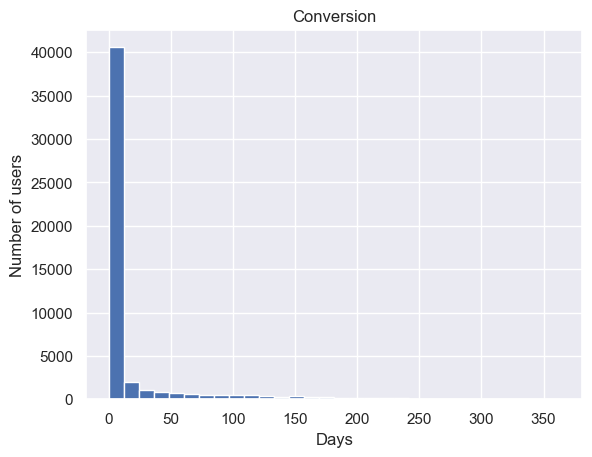

Median conversion value is 0.0 Days


In [37]:
#Adding the `first_activity_date` column to orders table
orders = orders.merge(first_activity_date, on = 'uid')
#Adjusting format of `first_activity_date` column
orders['first_activity_date'] = pd.to_datetime(orders['first_activity_date'])

#Creating `purchase_time` col'purchase_time'] >0][umn in orders table.
orders['purchase_time'] = (
    (orders.first_purchase_date - orders.first_activity_date)/np.timedelta64(1, 'D')).astype('int')

#Plotting a histogra,
orders['purchase_time'].hist(bins= 30)
plt.title('Conversion')
plt.xlabel('Days')
plt.ylabel('Number of users')
plt.show()
print('Median conversion value is', orders['purchase_time'].median(), 'Days')

In [38]:
orders['purchase_time'].describe()

count    50415.000000
mean        17.611227
std         46.469172
min          0.000000
25%          0.000000
50%          0.000000
75%          4.000000
max        363.000000
Name: purchase_time, dtype: float64

We see that people usually order something in the same day. 75% of people make the first order within 4 days. But let's find how many people convert at all?  We will divide unique users in orders table to unique users in visits table

In [39]:
#Printing overal conversion
print(' The overall conversion is {:.1%}'.format(orders['uid'].nunique()/visits['uid'].nunique()))

 The overall conversion is 16.0%


So, only 16% of users made at least one order.

### Number of orders per month for each cohort
In order to calculate how many orders do users of different cohorts have in each month we need to perform cohort analysis with our orders table. We will perform the same actions that we did in our visits table but now we need to work with `first_purchase_date` column to calculate `first_buy_month` and `lifetime` columns.

In [40]:
#Creating `first_buy_month`  and `buy_month` columns
orders['first_buy_month'] = (orders.first_purchase_date - pd.to_timedelta(
    orders.first_purchase_date.dt.day, unit='d') + timedelta(days=1)).dt.date
orders['buy_month'] = (orders.buy_ts - pd.to_timedelta(
    orders.buy_ts.dt.day, unit='d') + timedelta(days=1)).dt.date

#Creating `cohort_lifetime`column
orders['cohort_lifetime'] = ((
    orders['buy_month'] - orders['first_buy_month']) / np.timedelta64(1,'M')).round().astype('int')
   
#Checking what was done
orders.sample(5)

,buy_ts,revenue,uid,first_purchase_date,first_activity_date,purchase_time,first_buy_month,buy_month,cohort_lifetime
12663,2017-09-27 01:01:00,5.50,8165452349436286912,2017-09-27 01:01:00,2017-09-27,0,2017-09-01,2017-09-01,0
47844,2018-05-11 11:37:00,0.98,3753959787525756680,2018-05-11 11:37:00,2018-05-11,0,2018-05-01,2018-05-01,0
45140,2018-04-09 22:31:00,8.55,15831159067532708161,2018-04-09 22:31:00,2018-04-09,0,2018-04-01,2018-04-01,0
13214,2017-09-29 21:35:00,4.58,17252462709033655735,2017-09-29 21:35:00,2017-09-29,0,2017-09-01,2017-09-01,0
41094,2018-03-07 15:46:00,4.08,3706931466162209112,2018-03-07 15:46:00,2018-03-07,0,2018-03-01,2018-03-01,0


We have successfully calculated cohort lifetime in months and now we can make cohorts_buy table and calculate cohort size and number of orders per each month per each cohort  with pivot table.

In [41]:
#Creating cohort_buy table
cohorts_buy = orders.groupby(['first_buy_month', 'cohort_lifetime']).agg({'uid':['count','nunique']}).reset_index()
cohorts_buy.columns = ['first_buy_month', 'cohort_lifetime', 'n_orders', 'n_buyers']

#Calculating the initial number of users for each cohort
init_uid_buy = cohorts_buy[cohorts_buy['cohort_lifetime']==0][['first_buy_month', 'n_buyers']]
#Renaming the column for initial number of cohort buyers
init_uid_buy=init_uid_buy.rename(columns={'n_buyers':'cohort_count'})

#Adding the column `cohort_count` and calculating `orders_per_buer` in cohorts_buy table
cohorts_buy = cohorts_buy.merge(init_uid_buy, on='first_buy_month')
cohorts_buy['orders_per_buyer'] = cohorts_buy.n_orders / cohorts_buy.cohort_count

#Creating pivot
cohorts_buy_pivot = cohorts_buy.pivot_table(
    index='first_buy_month', columns='cohort_lifetime', values = 'orders_per_buyer', aggfunc='sum')

#Checking the result
cohorts_buy_pivot.round(2).fillna('')

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_buy_month,,,,,,,,,,,,
2017-06-01,1.16,0.09,0.09,0.11,0.14,0.11,0.14,0.09,0.1,0.08,0.05,0.04
2017-07-01,1.14,0.05,0.06,0.05,0.04,0.04,0.03,0.03,0.03,0.01,0.03,
2017-08-01,1.12,0.08,0.07,0.06,0.06,0.05,0.04,0.06,0.03,0.03,,
2017-09-01,1.14,0.08,0.06,0.06,0.03,0.04,0.04,0.02,0.02,,,
2017-10-01,1.14,0.07,0.04,0.03,0.03,0.02,0.02,0.03,,,,
2017-11-01,1.18,0.1,0.04,0.05,0.03,0.01,0.02,,,,,
2017-12-01,1.15,0.06,0.05,0.04,0.02,0.02,,,,,,
2018-01-01,1.12,0.07,0.05,0.02,0.02,,,,,,,
2018-02-01,1.12,0.06,0.02,0.02,,,,,,,,


Now let's find cumulative sum to compare the cohorts

In [42]:
#Creating pivot
cohorts_buy_pivot = cohorts_buy.pivot_table(
    index='first_buy_month', columns='cohort_lifetime', values = 'orders_per_buyer', aggfunc='sum').cumsum(axis=1)

#Checking the result
cohorts_buy_pivot.round(2).fillna('')

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_buy_month,,,,,,,,,,,,
2017-06-01,1.16,1.25,1.34,1.45,1.59,1.7,1.84,1.92,2.03,2.1,2.15,2.19
2017-07-01,1.14,1.19,1.25,1.31,1.34,1.39,1.42,1.44,1.47,1.49,1.51,
2017-08-01,1.12,1.2,1.27,1.33,1.39,1.44,1.47,1.53,1.56,1.6,,
2017-09-01,1.14,1.22,1.28,1.35,1.37,1.42,1.46,1.48,1.5,,,
2017-10-01,1.14,1.22,1.25,1.28,1.31,1.34,1.35,1.38,,,,
2017-11-01,1.18,1.28,1.32,1.37,1.41,1.42,1.45,,,,,
2017-12-01,1.15,1.21,1.26,1.3,1.32,1.34,,,,,,
2018-01-01,1.12,1.19,1.24,1.25,1.28,,,,,,,
2018-02-01,1.12,1.18,1.21,1.22,,,,,,,,


We see that our first cohort has the biggest number of orders per user per month. It has 2.19 orders per user in total. The second place won the August Cohort with total 1.6 orders per buyer in total. 

### Average order size
No we need to calculate the average purchase size. It is just an average revenue of each order. We can make a pivot table to find this value.<br>We have users revenue for each cohort in orders table. So we can simply create a pivot and plot a graph for total mean purchase size

In [43]:
#Calculating average order size
order_size = orders.pivot_table(
    index='first_buy_month', columns = 'cohort_lifetime', values = 'revenue', aggfunc='mean')

#Adding the totals
order_size.loc['Mean'] = order_size.mean(numeric_only=True, skipna=True, axis=0)
order_size = pd.concat([order_size, order_size.mean(numeric_only=True, skipna=True, axis=1).rename('Mean')], axis=1)

#Printing the result
order_size.round(2).fillna('')

,0,1,2,3,4,5,6,7,8,9,10,11,Mean
first_buy_month,,,,,,,,,,,,,
2017-06-01,4.06,5.55,5.09,8.55,7.08,6.83,6.97,6.76,5.28,8.01,12.04,6.04,6.85
2017-07-01,5.29,6.45,9.99,6.64,4.72,3.66,3.79,5.45,5.35,11.79,5.65,,6.25
2017-08-01,4.72,5.99,6.28,6.62,7.96,6.27,5.89,7.11,8.7,5.6,,,6.51
2017-09-01,4.97,13.17,8.35,62.57,15.43,15.32,16.77,11.21,7.79,,,,17.29
2017-10-01,4.37,7.41,5.13,5.59,5.1,5.07,4.28,4.01,,,,,5.12
2017-11-01,4.37,4.1,4.47,6.28,4.44,3.73,4.6,,,,,,4.57
2017-12-01,4.11,4.23,20.07,26.08,15.95,14.11,,,,,,,14.09
2018-01-01,3.69,4.44,6.45,7.52,2.71,,,,,,,,4.96
2018-02-01,3.71,4.58,3.45,3.87,,,,,,,,,3.90


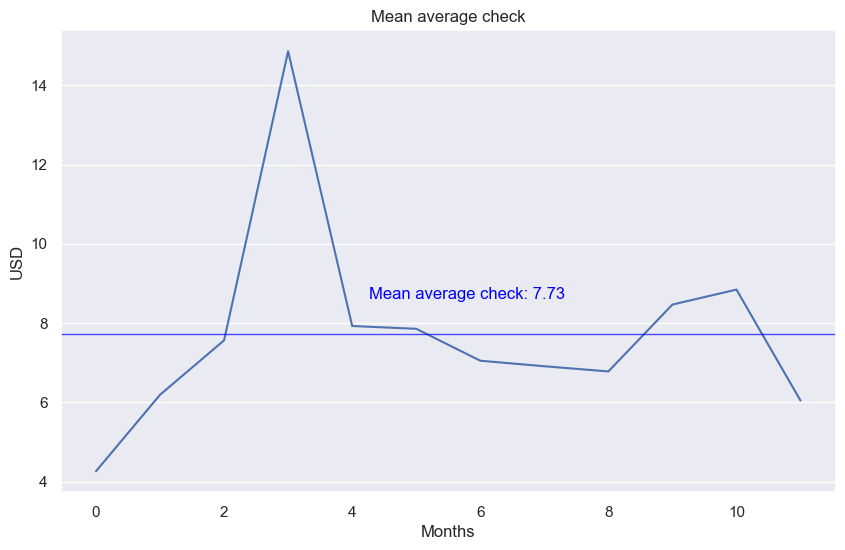

In [44]:
#Creating dataFrame with mean average check
order_size_mean = order_size.tail(1).drop(['Mean'], axis=1).T

#Plotting line graph 
fig, ax = plt.subplots(figsize = (10,6))
ax.grid(axis ='y')
ax.plot(order_size_mean)

#Adding h-line with mean number of session per user
check_mean = order_size_mean['Mean'].mean()
plt.axhline(y=check_mean, linewidth=1, color = 'blue', alpha = 0.7)
ax.text(order_size_mean['Mean'].iloc[0], check_mean+1, f"Mean average check: {check_mean:.2f}", 
       color='blue', va='center')

#Adding additional info
ax.set_xlabel('Months')
ax.set_ylabel('USD')
ax.set_title('Mean average check')
plt.show()

Let's compare average check with total revenue

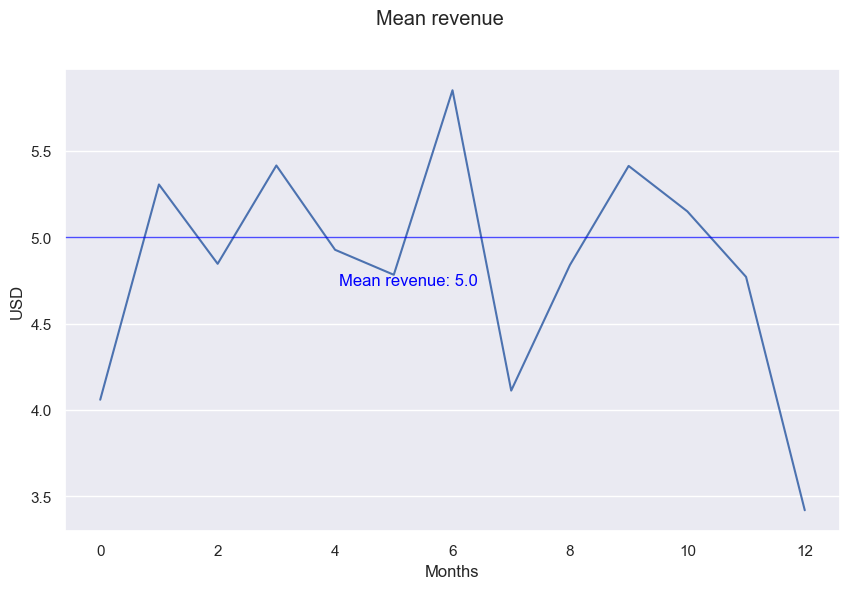

In [45]:
#Calculating revenue distribution over time
rev_graph = orders.groupby('buy_month')['revenue'].mean().reset_index()

#Plotrev_graphting line graph 
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(rev_graph['revenue'])
ax.grid(axis='y')

#Adding h-line with mean revenue
rev_mean = orders.revenue.mean()
plt.axhline(y=rev_mean, linewidth=1, color = 'blue', alpha = 0.7)
ax.text(rev_graph['revenue'].iloc[0], rev_mean-0.25, f"Mean revenue: {rev_mean:.1f}", color='blue', va='center')

#Adding additional info
plt.xlabel('Months')
plt.ylabel('USD')
plt.suptitle('Mean revenue')
plt.show()

We see that mean revenue is almost stable around the mean after the first month. It decreases just during the last month of the analysis.

We see that the total average order size is 7.73 usd. And we have almost the same average check in our first cohort (6.85) The September Cohort has the maximum average check of 17.29 usd. The December cohort has average check of 14 usd. Generally Average check is growing for the first June cohort, But in last month it dropped to average value. The September and December cohorts have the biggest average check in March (62.57 and 26.08 usd accordingly), then it decreases. 
### LTV
Now let's determine LTV (lifetime value of users) for each cohort. In other words we will calculate how much money does user bring to the company within his lifetime period. We have already calculated the number of users in each cohort, so we will calculate the revenue per each lifetime month in each cohort, merge this table with cohort size, then we will divide the revenue in each cohort to the number of users and we will get the average revenue per user.  Total average check is grouwing within the first 3 months up to the maximum value of 14.9usd, then it decreases to average value. In the last month it drops below the average to 6 usd. 

In [46]:
#Sum up the revenue
cohorts_rev = orders.groupby(['first_buy_month', 'cohort_lifetime']).agg({'revenue':'sum'}).reset_index()

#Merging the table with init_uid_buy
cohorts_rev = cohorts_rev.merge(init_uid_buy, on = 'first_buy_month')

#Calculating the evarage revenue per user
cohorts_rev['ltv'] = cohorts_rev.revenue / cohorts_rev.cohort_count

#Checking what was done
cohorts_rev.sample(5)

,first_buy_month,cohort_lifetime,revenue,cohort_count,ltv
30,2017-08-01,7,554.86,1370,0.405007
21,2017-07-01,9,282.96,1923,0.147145
63,2018-01-01,0,13949.50,3373,4.135636
47,2017-10-01,5,522.37,4340,0.120362
38,2017-09-01,5,1670.08,2581,0.647067


We got all needed information. Now let's make a pivot with cumulative sum  and plot heat map to visualize the results of the analysis

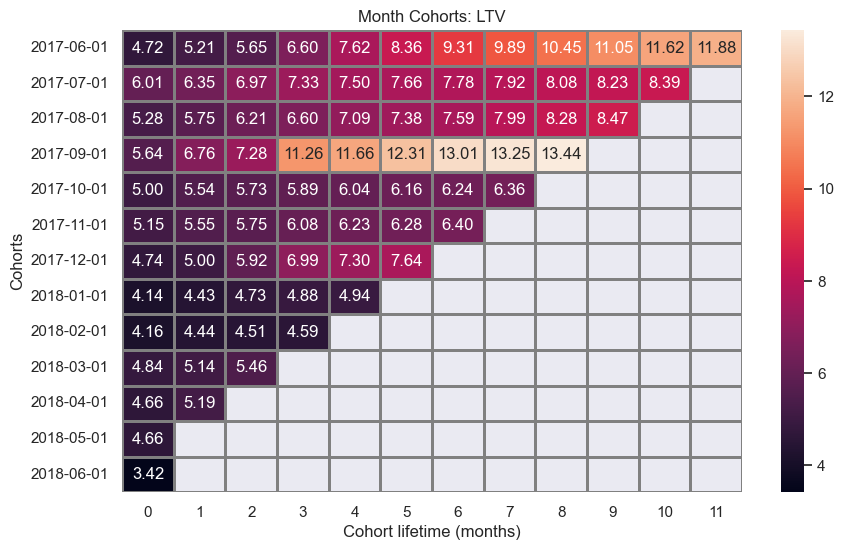

In [47]:
# Creating LTV picot table
ltv = cohorts_rev.pivot_table(
    index='first_buy_month', columns='cohort_lifetime', values = 'ltv', aggfunc='sum').cumsum(axis=1)

#Plotting heat map
sns.set(style='dark')
plt.figure(figsize=(10,6))
sns.heatmap(ltv, annot=True, fmt = '.2f', linewidths=1, linecolor='gray')
plt.title('Month Cohorts: LTV')
plt.xlabel('Cohort lifetime (months)')
plt.ylabel('Cohorts')
plt.show()

In terms of revenue the best Cohort is September Cohorts. Each user from this cohort gives us 13.44 usd. Our first June Cohorts has also good results.  Each user from that cohorts gives us 11.88 usd. Users from other cohorts does not bring us more than 9 usd. 

##  Marketing reports and metrics
During Marketing analysis we will find out the following:
1. How much money was spent? Overall, per source and over time.
2. How much did customer acquisition from each of the sources cost?
3. How worthwhile where the investments? (ROI)

### Costs over time and per different ad sources
Let's find total costs and build a graph showing marketing costs of different ad sources. We will need only costs table for that task

In [48]:
print('Total marketing cost is {} usd'.format(costs['costs'].sum()))

Total marketing cost is 329131.62 usd


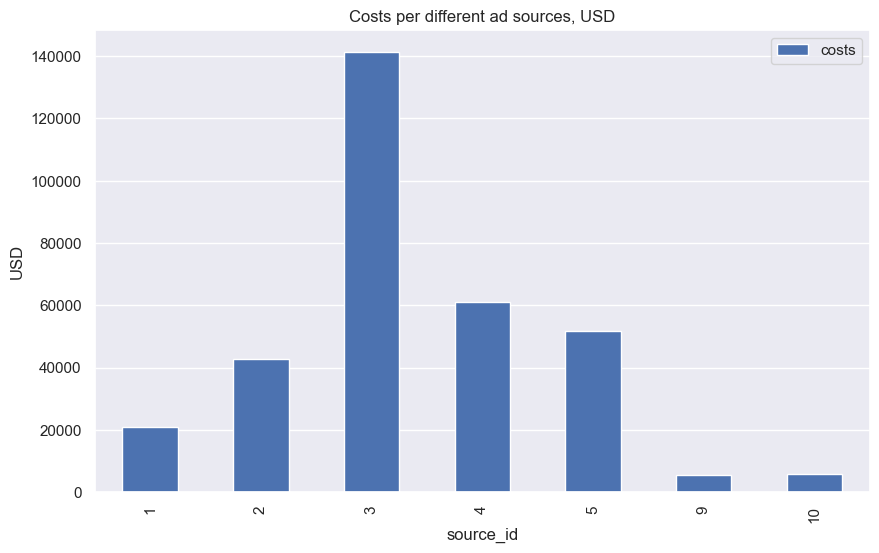

,source_id,costs
2,3,141321.63
3,4,61073.60
4,5,51757.10
1,2,42806.04
0,1,20833.27
6,10,5822.49
5,9,5517.49


In [49]:
#Grouping costs with device column
costs_dev = costs.groupby('source_id')['costs'].sum().reset_index()

#Plotting the bar graph
costs_dev.plot(kind = 'bar', x = 'source_id', y = 'costs', figsize = (10,6)).grid(axis = 'y')
plt.ylabel('USD')
plt.title('Costs per different ad sources, USD')
plt.show()

#Printing costs_dev table
costs_dev.sort_values('costs', ascending=False)

So, the most expensive is the source N3. We spent more than 140 000 usd for acquisition through that source. Later we will analyze whether this source is most profitable. 
Now let's build a graph showing costs of different sources spent through time. In order to do it we will perform the following actions. We will sum up the costs using with `source_id` and `dt`columns and plot line graphs.

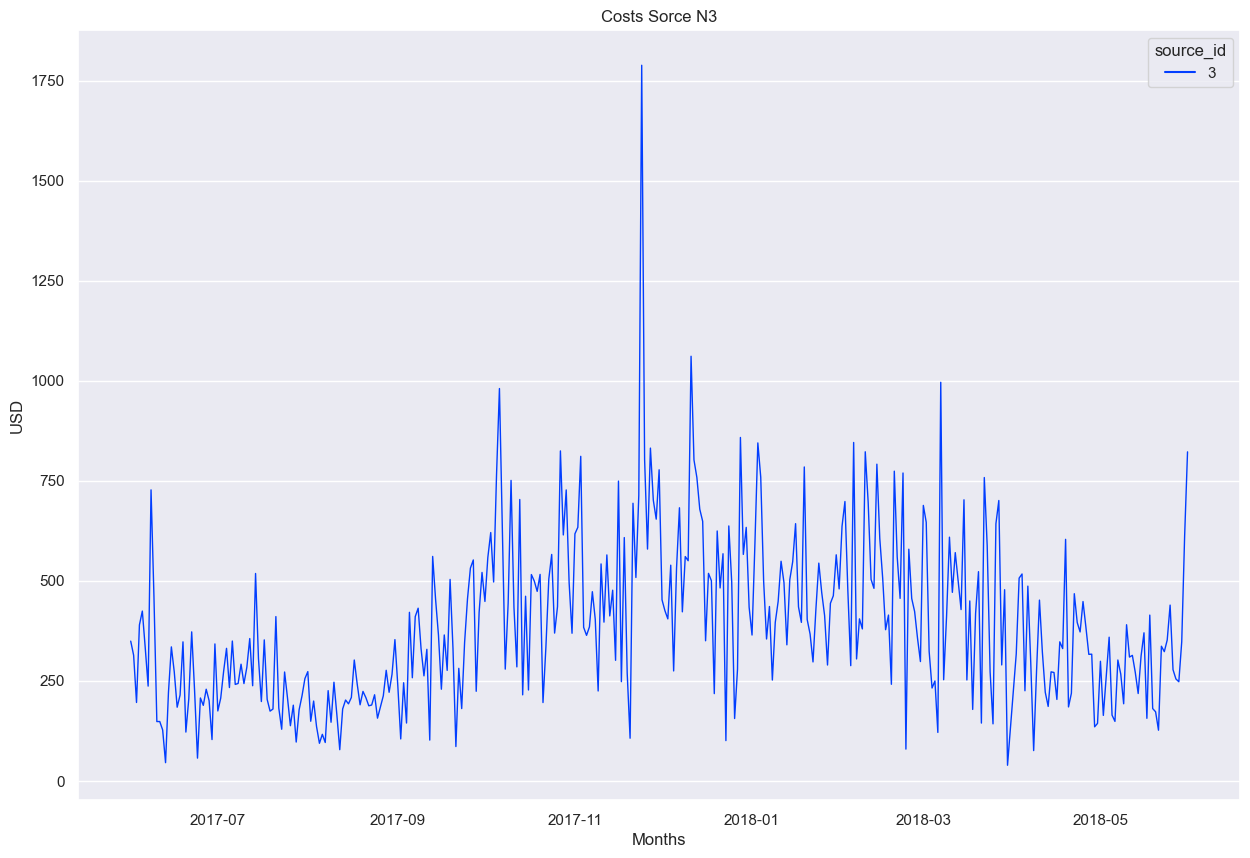

In [50]:
#Grouping costs with `source` column
costs_source = costs.groupby(['source_id', 'dt'])['costs'].sum().reset_index()

#Plotting linegraph for the most expansive source N3
plt.figure(figsize = (15,10))
ax = sns.lineplot(
        data=costs_source.query('source_id==3'), 
        x='dt', y='costs', hue='source_id', linewidth=1,
        palette=sns.color_palette("bright", 1)
     )
ax.grid(axis='y')
ax.set_title('Costs Sorce N3')
ax.set_xlabel('Months')
ax.set_ylabel('USD')
plt.show()

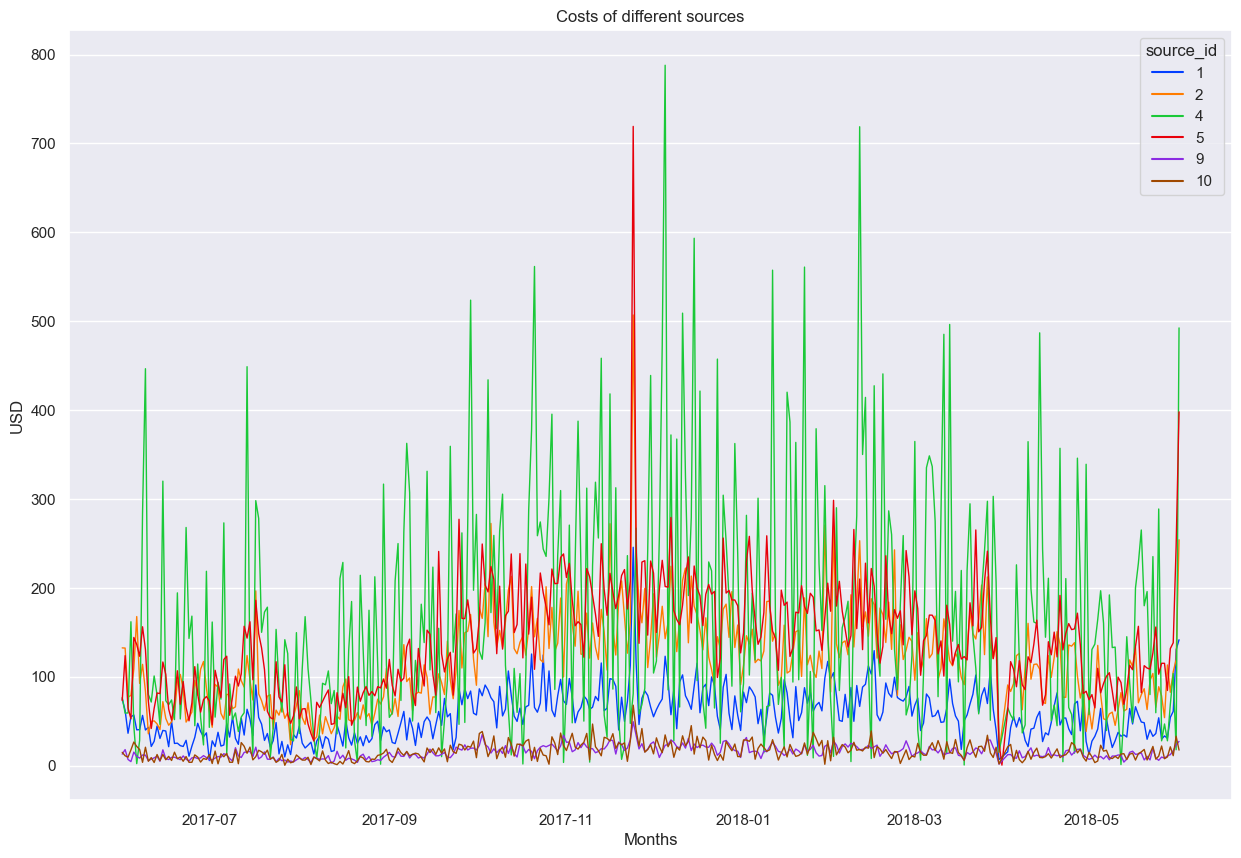

In [51]:
#Plotting linegraph for other sources
plt.figure(figsize = (15,10))
ax = sns.lineplot(
        data=costs_source.query('source_id!=3'), 
        x='dt', y='costs', hue='source_id', linewidth=1,
        palette=sns.color_palette("bright", 6)
     )
ax.grid(axis='y')
ax.set_title('Costs of different sources')
ax.set_xlabel('Months')
ax.set_ylabel('USD')
plt.show()

Let's sum up all the sources. The easiest way is to set `dt` column as index and resample the costs summing them up in monthly basis.

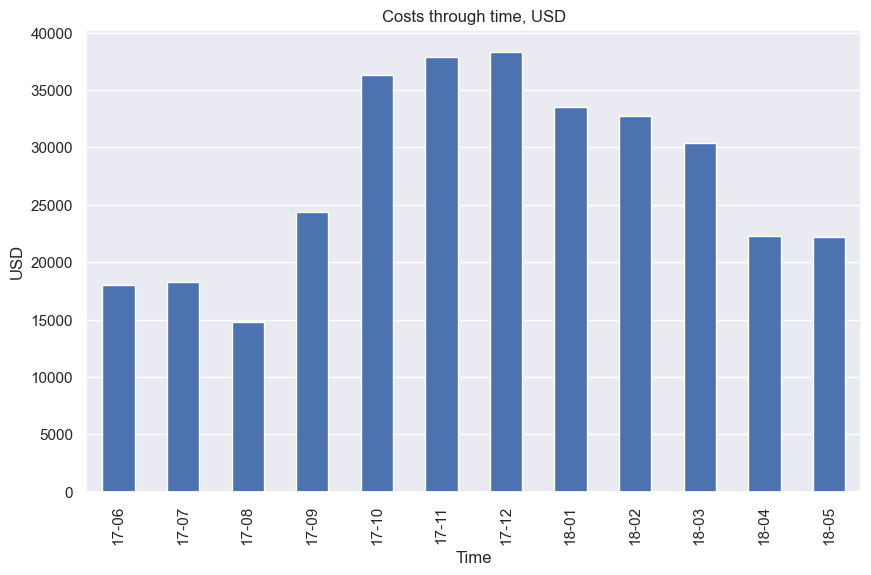

In [52]:
#Calculating costs in different months
costs.set_index('dt', inplace=True)
costs_month = costs['costs'].resample('M').sum()

#Plotting the bar graph
costs_month.index = costs_month.index.strftime('%y-%m')
costs_month.plot(kind = 'bar', x = 'dt', y = 'costs', figsize = (10,6)).grid(axis = 'y')
plt.ylabel('USD')
plt.title('Costs through time, USD')
plt.xlabel('Time')
plt.show()


So,  marketing costs grew till the end of 2017 year, after that the began to decrease. We have already notices that retention rate began to increase in that period of time. So this could be a result of spending more money on users acquisition. But after decreasing costs the retention rate decreased  also, so there is a correlation. we will find out whether there is good profit in the end of 2017 year to make a conclusion whether those big marketing costs are worthy.

### Cost of user acquisition in time


For customer acquisition we need to group costs by month. Let's do it in the way we did it for orders. We can create `dt_month` column from `dt` and then we will group the costs.

In [53]:
#Creating `dt_month` column in costs table
costs = costs.reset_index()
costs['dt_month'] = (costs['dt'] - pd.to_timedelta(costs['dt'].dt.day, unit='d') + timedelta(days=1)).dt.date

#Grouping costs by month
costs_month = costs.groupby('dt_month')['costs'].sum().reset_index()

#Checking the result
costs_month.sample(5)

,dt_month,costs
8,2018-02-01,32723.03
5,2017-11-01,37907.88
7,2018-01-01,33518.52
10,2018-04-01,22289.38
9,2018-03-01,30415.27


Now let's sum up the buyers from the orders table. In order to get correct result we will count the buyers from the first month of their order

In [54]:
#Creating buyers_month table
buyers_month = orders.groupby('first_buy_month')['uid'].nunique().reset_index()
#Renaming the columns
buyers_month.columns = ['dt_month', 'n_buyers']
#Checking the result
buyers_month.sample(5)

,dt_month,n_buyers
1,2017-07-01,1923
7,2018-01-01,3373
5,2017-11-01,4081
2,2017-08-01,1370
10,2018-04-01,2276


Now we can merge the tables, calculate CAC and make a line plot to visualize haw CAC changes in time 

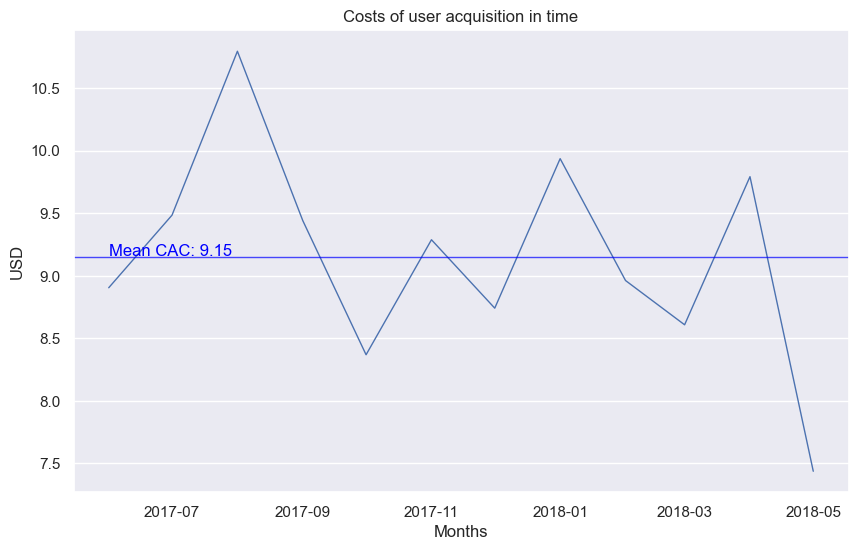

In [55]:
# Merging the cost_month and buyers_month tables
costs_month = costs_month.merge(buyers_month, on='dt_month')
#Calculating CAC
costs_month['cac'] = costs_month.costs / costs_month.n_buyers

#Plotting line graph
plt.figure(figsize = (10,6))
ax = sns.lineplot(data=costs_month, x='dt_month', y='cac', linewidth=1, palette=sns.color_palette("bright", 1))
ax.grid(axis='y')

#Calculating mean CAC
cac_mean = float(costs_month['cac'].mean())
#Plotting h-line with the mean CAC
plt.axhline(y=cac_mean, linewidth=1, color = 'blue', alpha = 0.7)
ax.text(costs_month['dt_month'].iloc[0], cac_mean +0.05, f"Mean CAC: {cac_mean:.2f}", color='blue', va='center')

#Plotting additional info
ax.set_title('Costs of user acquisition in time')
ax.set_xlabel('Months')
ax.set_ylabel('USD')
plt.show()

We see that average costs per acquisition of one user are 9.15 usd. They are valuating from 8.5 to 10 usd in average, but we have peek in August 2017 where they are on the maximum level of 10.8 usd and there is a drop in May 2018 where they dropped below 7.5 usd.

### CAC per source
In order to calculate costs per every source per every user we need first to find the first source for each user. We can do this from visits table. Then we will merge this column with orders table and group orders table with `buy_date` and `source_id` columns. After that we can sump up orders and costs tables to get number of buyers per source per month and costs per source per month. Then we will calculate CAC per source and plot line graph

In [56]:
#Calculating table with the first source for each user
user_source  = visits.sort_values(['start_ts']).groupby('uid')['source_id'].first().reset_index()

#Adding user_sorce column to orders table.
orders = orders.merge(user_source, on = 'uid')

#Grouping orders table with buy_date and source_id to find number of users per each source per each cohort (first month)
buyers_month_source = orders.groupby(['first_buy_month', 'source_id'])['uid'].nunique().reset_index()

#Checking what was done
buyers_month_source.head()

,first_buy_month,source_id,uid
0,2017-06-01,1,190
1,2017-06-01,2,235
2,2017-06-01,3,638
3,2017-06-01,4,413
4,2017-06-01,5,384


Now we can sum up costs table in the same way

In [57]:
#Creating cost_month_source table
cost_month_source = costs.groupby(['dt_month', 'source_id'])['costs'].sum().reset_index()

#Checking the result
cost_month_source.head()

,dt_month,source_id,costs
0,2017-06-01,1,1125.61
1,2017-06-01,2,2427.38
2,2017-06-01,3,7731.65
3,2017-06-01,4,3514.80
4,2017-06-01,5,2616.12


Now we need to change column name `first_buy_month` to `dt_month` in order to merge our tables and calculate CAC per source per month. Let's do this

In [58]:
#Renaming the columns
buyers_month_source.rename(columns={'first_buy_month':'dt_month', 'uid': 'n_buyers'}, inplace=True)
#Merging the tables
cost_month_source = cost_month_source.merge(
    buyers_month_source, how='left', left_on = ['dt_month', 'source_id'], right_on = ['dt_month', 'source_id'])
#Calculating CAC per source
cost_month_source['cac_source'] = cost_month_source.costs / cost_month_source.n_buyers

#Checking the result
cost_month_source.head()

,dt_month,source_id,costs,n_buyers,cac_source
0,2017-06-01,1,1125.61,190,5.924263
1,2017-06-01,2,2427.38,235,10.329277
2,2017-06-01,3,7731.65,638,12.118574
3,2017-06-01,4,3514.80,413,8.510412
4,2017-06-01,5,2616.12,384,6.812812


Now we can plot line bar to see the dynamic of CAC of different sources

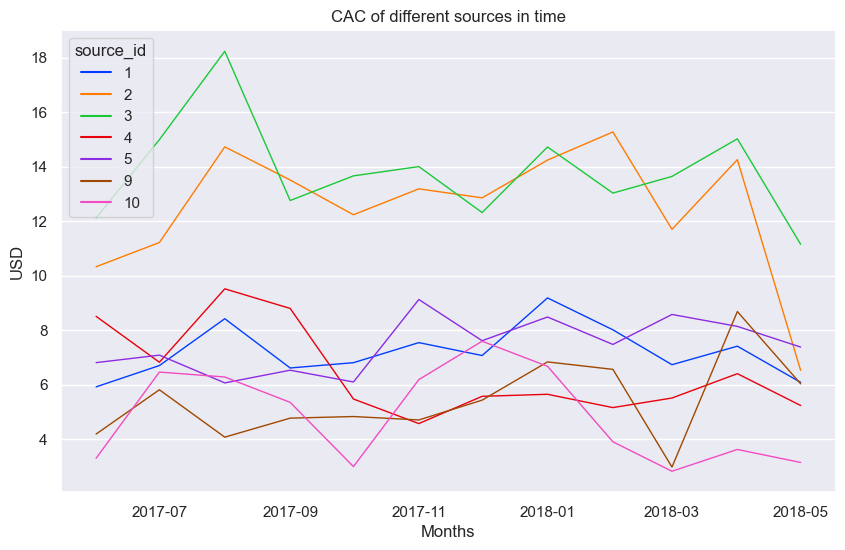

In [59]:
#Plotting line graph
plt.figure(figsize = (10,6))
ax = sns.lineplot(data=cost_month_source, x='dt_month', y='cac_source',
                  hue = 'source_id', linewidth=1, palette=sns.color_palette("bright", 7))
ax.grid(axis='y')

#Plotting additional info
ax.set_title('CAC of different sources in time')
ax.set_xlabel('Months')
ax.set_ylabel('USD')
plt.show()

Let's also calculate overall average CAC per source to make our conclusions slightly better

In [60]:
cac_source_mean = (cost_month_source.groupby('source_id')['cac_source'].mean()
                   .sort_values(ascending = False).reset_index()
                  )
cac_source_mean

,source_id,cac_source
0,3,13.802743
1,2,12.504068
2,5,7.451938
3,1,7.212107
4,4,6.439374
5,9,5.413892
6,10,4.867125


We see that the most expansive is source 3. Average CAC is 13.8 usd per source and this level of costs is mostly constant. We have only high peak in August, but then CAC dropped to the mean level and we have great decrease in May where CAC dropped to 11 usd per source. We have the same dynamic with source 2 which have an average CAC of 12.5 USD. The same dynamic have sources  1,5,4 and thy are more stable in time. But for Source 9 we have the opposite dynamic. Pretty much stable level of average about 5.4 usd and sudden increase in May to 8.5 usd. We have  very unstable CAC for source 10. Average CAC of that source is 4.9 usd but it changes from 3 to 8 usd and vise versa. 

### ROI
In order to calculate return on marketing investments we need to divide revenue per user to costs per user and find cumulative value of that. We have already calculated LTV and CAC, so let's start with ROI per cohort. We need just to merge the tables costs_month and cohorts_rev

In [61]:
#Creating costs_month_roi table from needed columns of costs_month table
costs_month_roi = costs_month[['dt_month', 'cac']]
#Renaming column `dt_month` in order to merge with cohorts_rev table
costs_month_roi.columns=['first_buy_month', 'cac']

#Creating roi table merging  the tables costs_month_roi and cohorts_rev
roi = cohorts_rev.merge(costs_month_roi, on = 'first_buy_month')

#Checking the result
roi.head()

,first_buy_month,cohort_lifetime,revenue,cohort_count,ltv,cac
0,2017-06-01,0,9557.49,2023,4.724414,8.905091
1,2017-06-01,1,981.82,2023,0.485329,8.905091
2,2017-06-01,2,885.34,2023,0.437637,8.905091
3,2017-06-01,3,1931.30,2023,0.954671,8.905091
4,2017-06-01,4,2068.58,2023,1.022531,8.905091


Now let's calculate ROI, make a pivot table with cumulative sum and plot a heat map to visualize the analysis

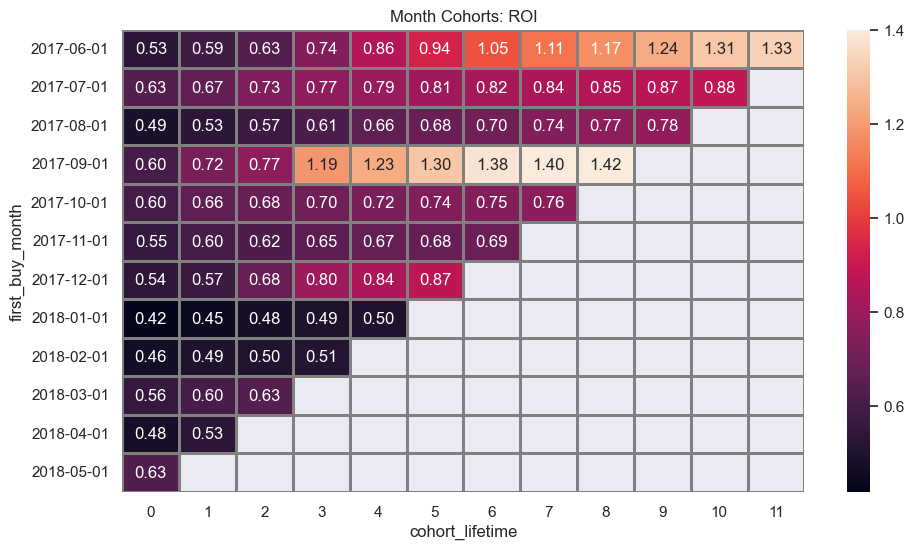

In [62]:
#Calculating ROI
roi['roi'] = roi.ltv / roi.cac

#Making pivot of roi
roi_pivot = roi.pivot_table(index='first_buy_month', columns = 'cohort_lifetime', values = 'roi', aggfunc = 'mean'
                           ).cumsum(axis = 1)

# plotting the heatmap of roi
sns.set(style='dark')
plt.figure(figsize=(11,6))
sns.heatmap(roi_pivot, annot=True, fmt='.2f', linewidths=1, vmax=1.4, linecolor='gray')
plt.title('Month Cohorts: ROI')
plt.show()


We see that only 2 cohorts are payed off. Our first June cohort is payed off from the 7th month so in December 2017 and finally it  has 33% of gross profit for a year. The most profitable is September cohort where was the biggest average check. It is profitable from the 4th month (December 2017 also) and it has gross profit of 42% for the whole analysis period. Costs for all other cohorts are bigger than revenue. So we would recommend to increase marketing costs as there is a correlation between those costs and retention rate that we have determined during the analysis.

Let's find ROI per source. May be we will see the difference. Now we have all needed info to aggregate and merge the tables

In [63]:
#Grouping orders table to find revenue per source
ltv_source = orders.groupby(['source_id'])['uid', 'revenue'].agg({'uid': 'nunique', 'revenue' :'sum'}).reset_index()
#Renaming the columns
ltv_source.rename(columns = {'uid':'n_buyers'}, inplace = True)

#Calculating ltv
ltv_source['ltv_source'] = ltv_source.revenue / ltv_source.n_buyers

#Checking what was done
ltv_source

C:\Users\Александр\AppData\Local\Temp\ipykernel_2760\2864165820.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  ltv_source = orders.groupby(['source_id'])['uid', 'revenue'].agg({'uid': 'nunique', 'revenue' :'sum'}).reset_index()


,source_id,n_buyers,revenue,ltv_source
0,1,2899,31090.55,10.724577
1,2,3506,46923.61,13.383802
2,3,10473,54511.24,5.204931
3,4,10296,56696.83,5.506685
4,5,6931,52624.02,7.592558
5,7,1,1.22,1.220000
6,9,1088,5759.40,5.293566
7,10,1329,4450.33,3.348631


Looks good. Now we can merge this table with cost_dev table, then we will calculate CAC per source and then we will calculate ROI per each source  

In [64]:
#Merging ltv_source and costs_dev tables with `source_id` column
roi_source = ltv_source.merge(costs_dev, on = 'source_id')

#Calculating CAC per source 
roi_source['cac_source'] = roi_source.costs / roi_source.n_buyers

#Calculating ROI
roi_source['roi'] = roi_source.ltv_source / roi_source.cac_source
 
#Checking the result
roi_source

,source_id,n_buyers,revenue,ltv_source,costs,cac_source,roi
0,1,2899,31090.55,10.724577,20833.27,7.186364,1.492351
1,2,3506,46923.61,13.383802,42806.04,12.209367,1.096191
2,3,10473,54511.24,5.204931,141321.63,13.493901,0.385725
3,4,10296,56696.83,5.506685,61073.60,5.931779,0.928336
4,5,6931,52624.02,7.592558,51757.10,7.467479,1.016750
5,9,1088,5759.40,5.293566,5517.49,5.071222,1.043844
6,10,1329,4450.33,3.348631,5822.49,4.381106,0.764335


Now let's plot a bar graph to visualize the analysis

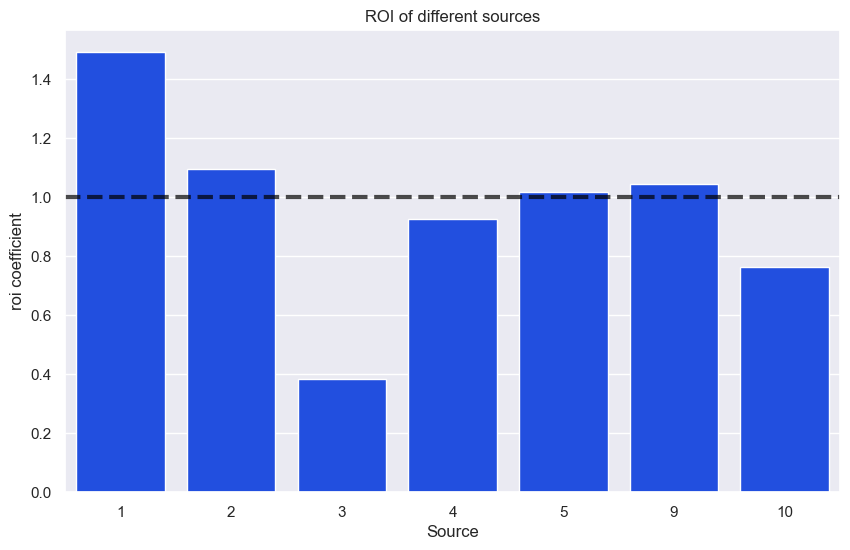

In [65]:
#Plotting bar graph
plt.figure(figsize = (10,6))
ax = sns.barplot(data=roi_source, x='source_id', y='roi',linewidth=1, palette=sns.color_palette("bright", 1))
ax.grid(axis='y')
plt.axhline(y=1, linewidth=3, color = 'black', alpha = 0.7, linestyle = '--')

#Plotting additional info
ax.set_title('ROI of different sources')
ax.set_xlabel('Source')
ax.set_ylabel('roi coefficient')
plt.show()

We see the different picture of ROI per source. The profitable sources are 1,2 5 and 9. The rest are not profitable. Our most expensive source 3 doesn't bring us enough revenue, only about 40% of marketing costs are payed off. So it is better to increase marketing costs in profitable sources in order to get more users and more revenue for the company.

# Overall conclusion
Being  analysts in the analytical department at Yandex.Afisha our task was to help optimize marketing expenses. We had server logs with data on Yandex.Afisha visits from June 2017 through May 2018, dump file with all orders for the period and marketing expenses statistics. Purposes of the analysis were to find out how people use the product, when they start to buy, how much money each customer brings to the company, when they pay off. 

We got data from 3 tables: visits, orders and costs. There were no missing values we just changed some column names to lowercase with the use of underscore between the words, after that we changed type of time stamp  columns in order to work with the dates properly. We changed type of `device` column from visits table to category type for better performance.

Then we analyzed the usage of the product by the users. We have 907 users, who use the product every day in average. Average number of weekly users -  5716 and average number of monthly users -  23228. **Only 16% of the users who have used the product at least once a week, continue to do it every day**,  and only 4% of the users who have used the product at least once a month, continue to use it every day. In addition we saw that about 25% of users who have used the service once a month us it weekly. **We saw that users open the product just once a day. Most often users spend just 1 minute using the product, but the half of the total number of users spend more than 6 minutes** during the one session. Anyway it is not a big time. Less then 10% of users continue using the product after the first week when they began to use it. The September Cohort has the highest  retention rate in the first month (8.5%) but it dropped more rapidly an in 3 months it drops to value less than 4%. The most successful cohort is the first one (June Cohort). They have 7.9% of users who continue to use the service in the next month after the first usage and the have this retention rate for the next 6 months. Then after 6 months retention rate begin to drop to 4.5% in May 2018. We see also that from December 2017 and in 2018 retention rate begins to drop for those cohorts to values below 6% in the first lifetime month. My be winter is not good tome for orders.

Regarding the sales metrics we found out that  **people usually order something in the same day. 75% of people make the first order within 4 days. But only 16% of users made at least one order.**

We discovered that our first cohort has the biggest number of orders per user per month. **It has 2.19 orders per user in total.** The second place won the August Cohort with total 1.6 orders per buyer in total.

**Average order size is 7.73 usd.** And we have almost the same average check in our first cohort (6.85) The September Cohort has the maximum average check of 17.29 usd. The December cohort has average check of 14 usd. Generally Average check is growing for the first June cohort, But in last month it dropped to average value. The September and December cohorts have the biggest average check in March (62.57 and 26.08 usd accordingly), then it decreases.

**In terms of revenue the best Cohort is September** Cohort. Each user from this cohort gives us **13.44 usd.** Our first June Cohorts has also good results. Each user from that cohorts gives us 11.88 usd. Users from other cohorts does not bring us more than 9 usd.

Regarding the marketing metrics we have analyzed the different ad sources in order to find out which of them gives the biggest profit and which is not profitable at all.  **The most expensive is the source N3. We spent more than 140 000 usd for acquisition through that source.** In general marketing costs grew till the end of 2017 year, after that the began to decrease. We have already notices that retention rate began to increase in that period of time. So this could be a result of spending more money on users acquisition. But after decreasing costs the retention rate decreased  also, so there is a correlation.

**The average costs per acquisition of one user are 9.15 usd.** They are valuating from 8.5 to 10 usd in average, but we have peek in August 2017 where they are on the maximum level of 10.8 usd and there is a drop in May 2018 where they dropped below 7.5 usd.

We see that the **most expansive is source 3. Average CAC is 13.8 usd per source and this level of costs is mostly constant.** We have only high peak in August, but then CAC dropped to the mean level and we have great decrease in May where CAC dropped to 11 usd per source. We have the same dynamic with source 2 which have an average CAC of 12.5 USD. The same dynamic have sources  1,5,4 and thy are more stable in time. But for Source 9 we have the opposite dynamic. Pretty much stable level of average about 5.4 usd and sudden increase in May to 8.5 usd. We have  very unstable CAC for source 10. Average CAC of that source is 4.9 usd but it changes from 3 to 8 usd and vise versa. 

Durin ROI analysis we saw that **only 2 cohorts are payed off**. Our first June cohort is payed off from the 7th month so in December 2017 and finally it  has 33% of gross profit for a year. The most profitable is September cohort where was the biggest average check. It is profitable from the 4th month (December 2017 also) and it has gross profit of 42% for the whole analysis period. Costs for all other cohorts are bigger than revenue. So **we would recommend to increase marketing costs as there is a correlation between those costs and retention rate** that we have determined during the analysis.

Finally we have evaluated the profitability of the different ad sources. We saw the different picture of ROI per source. **The profitable sources are 1,2,5 and 9. The rest are not profitable.** Our most expensive source 3 doesn't bring us enough revenue, only about 30% of marketing costs are payed off. So it is better to increase marketing costs in profitable sources in order to get more users and more revenue for the company.

**So we can conclude that our marketing is is not so good because only 3 ad sources and 2 cohorts are payed off and profitable. There is such correlation  that the more money we spend to users acquisition the more users we get. We found out that marketing expenses began to decrease in 2018, and this result in decrease in number of users. So, we would recommend to increase investments into marketing, this will result in more clients and more profit for the company. The  profitable sources are 1, 2 and 9. If we invest money for acquisition from those sources we will get the maximum profit for the company.**